In [1]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

实验设计：
- 从 Visium 删除一部分 spot，这些 spot 作为验证集。
- 将 dropped Visium 输入 iStar 进行超分，采用 VisiumHD 模式 8um super pixel size
- 将验证集 spot 所覆盖的像素加和作为预测值
- 计算 pcc, mse

In [2]:
from datasets import VisiumData, VisiumHDData
from models import iStar
from pathlib import Path
from profiles import VisiumProfile, VisiumHDProfile
import imageio.v2 as ii
import cv2
import random
import matplotlib.pyplot as plt

### 数据准备
DLPFC

In [3]:
visium_path = Path('/home/yiriso/Research/Super-resolvedST/data/DLPFC/sample_151673')
raw_visium = VisiumData()
visium_profile = VisiumProfile(slide_serial=1)
raw_visium.load(
    path=visium_path,
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
raw_visium.select_HVG(n_top_genes=2000,min_counts=10)

Start load
Finish load in 0.4152 s


随机删除 spot

In [4]:
drop_ids = random.sample(range(len(visium_profile)), 1000)
dropped_visium = raw_visium.drop_spots(spot_ids=drop_ids)

721 spots will be dropped.


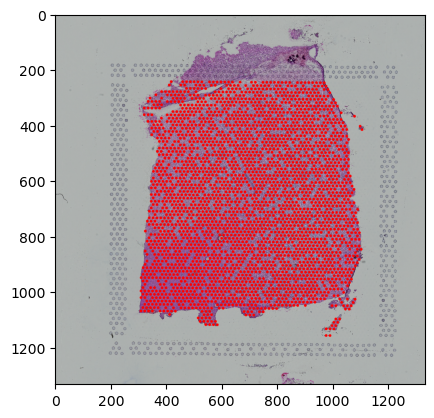

In [5]:
spot_img = dropped_visium.vision_spots(in_tissue=True)
plt.imshow(cv2.resize(spot_img, None, fx=0.1, fy=0.1))

将删除 spot 的数据保存

In [6]:
dropped_visium.save("DLPFC_dropped")

Start save
Finish save in 1.3597 s


/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/utility.py:170: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['feature_type'] = 'Gene Expression'


### 使用 iStar 超分

使用 VisiumHD 模式，tissue_positions 保存了配置信息

In [7]:
visiumHD_profile = VisiumHDProfile(bin_size=8)
visiumHD_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col
0,0,s_008um_00000_00000-1,0,0,4.0,4.0
1,1,s_008um_00000_00001-1,0,1,4.0,12.0
2,2,s_008um_00000_00002-1,0,2,4.0,20.0
3,3,s_008um_00000_00003-1,0,3,4.0,28.0
4,4,s_008um_00000_00004-1,0,4,4.0,36.0
...,...,...,...,...,...,...
700564,700564,s_008um_00836_00832-1,836,832,6692.0,6660.0
700565,700565,s_008um_00836_00833-1,836,833,6692.0,6668.0
700566,700566,s_008um_00836_00834-1,836,834,6692.0,6676.0
700567,700567,s_008um_00836_00835-1,836,835,6692.0,6684.0


读取构建的 dropped 数据，设置遮掩，生成 VisiumHD 结果半成品（缺乏表达量信息）

In [8]:
istar_visium = iStar()
istar_visium.load(
    path="DLPFC_dropped",
    profile=visium_profile,
    source_image_path=visium_path/"151673_full_image.tif"
)
istar_visium.tissue_mask(mask_image_path=visium_path/"mask.png")
visiumHD_demo = istar_visium.Visium2HD(visiumHD_profile)

Start load
Finish load in 0.1724 s


/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 0) cover rate: 86.11%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 2) cover rate: 85.29%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 4) cover rate: 86.11%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 6) cover rate: 85.29%, that 5 bins outside the gr

警告提示 spot 覆盖了超出 visiumHD 测序范围的 bin，在这个实验中并无影响，tissue_positions 中可以得到具体信息。

In [18]:
visium_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col,pxl_row_in_fullres,pxl_col_in_fullres,num_bin_in_spot,num_bin_out_spot
0,0,ATACGAAACCCCGCGT-1,0,0,27.500000,27.5,2427,2811,31,5
1,1,AAAGAGTAGATCGTAG-1,1,1,114.102540,77.5,2547,2879,38,0
2,2,AACGTGACCCAAGTGT-1,0,2,27.500000,127.5,2428,2949,29,5
3,3,GAATAATGATCAGGTG-1,1,3,114.102540,177.5,2548,3017,37,0
4,4,GATTTGTCGGTTGTCC-1,0,4,27.500000,227.5,2429,3086,31,5
...,...,...,...,...,...,...,...,...,...,...
4987,4987,CTTTAGCGTTATTACA-1,77,123,6695.895609,6177.5,11713,11214,31,8
4988,4988,TACAGTGATGTACTGA-1,76,124,6609.293069,6227.5,11594,11283,37,0
4989,4989,AACTCTGGAACAAGGT-1,77,125,6695.895609,6277.5,11714,11351,29,7
4990,4990,CTATGGAGCGATCTTC-1,76,126,6609.293069,6327.5,11595,11421,38,0


同时 visiumHD 的配置文件中也会保存映射情况。

In [19]:
visiumHD_profile.tissue_positions

,id,barcode,array_row,array_col,frame_row,frame_col,pxl_row_in_fullres,pxl_col_in_fullres,spot_label
0,0,s_008um_00000_00000-1,0,0,4.0,4.0,2411.381645,2578.366496,0
1,1,s_008um_00000_00001-1,0,1,4.0,12.0,2411.461258,2589.383447,0
2,2,s_008um_00000_00002-1,0,2,4.0,20.0,2411.540870,2600.400398,0
3,3,s_008um_00000_00003-1,0,3,4.0,28.0,2411.620483,2611.417350,0
4,4,s_008um_00000_00004-1,0,4,4.0,36.0,2411.700095,2622.434301,0
...,...,...,...,...,...,...,...,...,...
700564,700564,s_008um_00836_00832-1,836,832,6692.0,6660.0,11730.043895,11677.615779,0
700565,700565,s_008um_00836_00833-1,836,833,6692.0,6668.0,11730.123508,11688.632730,0
700566,700566,s_008um_00836_00834-1,836,834,6692.0,6676.0,11730.203120,11699.649682,0
700567,700567,s_008um_00836_00835-1,836,835,6692.0,6684.0,11730.282733,11710.666633,0


为 istar 模型套用 VisiumHD 结果半成品，这将整理成 istar 的输入格式。

In [11]:
istar_visium.set_target_VisiumHD(visiumHD_demo)
istar_visium.save_input("istar_on_dropped")

Cropping patch image of each bin
[█████████████████████████████████████████████████ ] 99.9%


bash 运行 iStar 工具，具体命令根据 iStar-Run.sh 脚本的位置和 istar_on_dropped 的位置决定。

iStar 工具运行完成后，读取结果，并保存成 h5ad 格式和 VisiumHD 超分结果

In [20]:
istar_visium.load_output("istar_on_dropped")
istar_visium.to_h5ad()

Reading iStar output
[██████████████████████████████████████████████████] 100.0%
Start to_h5ad


/home/yiriso/anaconda3/envs/DataReader/lib/python3.10/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Finish to_h5ad in 4.8028 s


In [21]:
istar_visium.to_VisiumHD("istar_on_dropped/VisiumHD_result",visiumHD_demo)

Start to_VisiumHD
Start save
Finish save in 16.5106 s
Finish to_VisiumHD in 34.5336 s


### 将超分结果重新加和到 spot

In [22]:
superHD = VisiumHDData()
superHD.load(
    path="istar_on_dropped/VisiumHD_result",
    profile=visiumHD_profile,
    source_image_path="istar_on_dropped/VisiumHD_result/image.tif"
)

Start load
Finish load in 7.1801 s


/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/datasets.py:239: UserWarning: Using data in bin size of 8, recommed 2 um.
  warnings.warn(f"Using data in bin size of {self.bin_size}, recommed 2 um.")


In [23]:
superVisium = superHD.HD2Visium(profile=visium_profile)

Merge the gene expression from bins to the spot
[                                                  ] 1.5%

/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 0) cover rate: 86.11%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 2) cover rate: 85.29%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 4) cover rate: 86.11%, that 5 bins outside the grid.
  warnings.warn(f"Spot {profile.id2array(id)} cover rate: {covered_rate:0.2f}%, that {uncovered[id]:d} bins outside the grid.")
/home/yiriso/Research/Super-resolvedST/SuperResolvedST-Pipline/profiles.py:281: UserWarning: Spot (0, 6) cover rate: 85.29%, that 5 bins outside the gr

[██████████████████████████████████████████████████] 100.0%
